In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys

plt.rcParams["figure.figsize"] = (15, 10)

Finished simulation. Starting animation...
99%

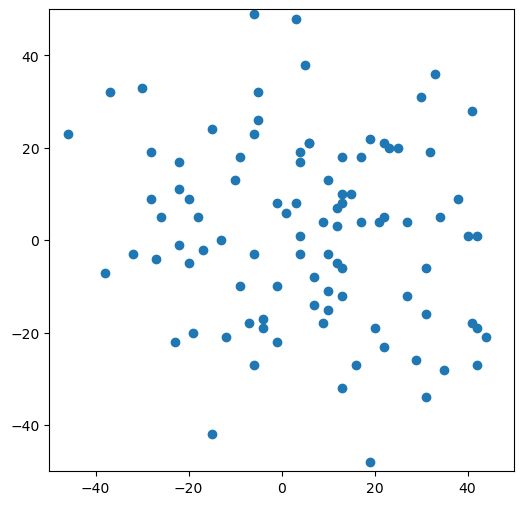

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def get_random_zero_or_one():
    return np.random.randint(0, 2)

def get_random_negative_positive_one():
    # returns either -1 or +1
    return (np.random.randint(0, 2) * -2) + 1

simulations_to_run = 100
steps_to_do = 1000

# correct initialization (no shared inner lists)
positions_x = [[0 for _ in range(simulations_to_run)] for _ in range(steps_to_do)]
positions_y = [[0 for _ in range(simulations_to_run)] for _ in range(steps_to_do)]

# run random walk: each step move either in x or y by ±1
for step in range(steps_to_do - 1):
    for sim in range(simulations_to_run):
        # start from previous position
        x_prev = positions_x[step][sim]
        y_prev = positions_y[step][sim]

        if get_random_zero_or_one() == 0:
            # move in x
            dx = get_random_negative_positive_one()
            dy = 0
        else:
            # move in y
            dx = 0
            dy = get_random_negative_positive_one()

        positions_x[step + 1][sim] = x_prev + dx
        positions_y[step + 1][sim] = y_prev + dy

print("Finished simulation. Starting animation...")

limit = int(steps_to_do / 20)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_ylim(-limit, limit)
ax.set_xlim(-limit, limit)

# initial scatter; note this returns a PathCollection
campo = ax.scatter([], [])

def init():
    # initialize with empty offsets
    campo.set_offsets(np.empty((0, 2)))
    return (campo,)

def animate(i):
    sys.stdout.write("\r")
    sys.stdout.write(str(int(100*(i/steps_to_do))) + "%")
    sys.stdout.flush()
    xs = positions_x[i]
    ys = positions_y[i]
    # set_offsets expects an (N,2) array
    coords = np.column_stack((xs, ys))
    campo.set_offsets(coords)
    return (campo,)

# create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=steps_to_do,
    interval=20,
    blit=True
)

# save to mp4 (requires ffmpeg); fps value can be chosen as desired
anim.save('fluid_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

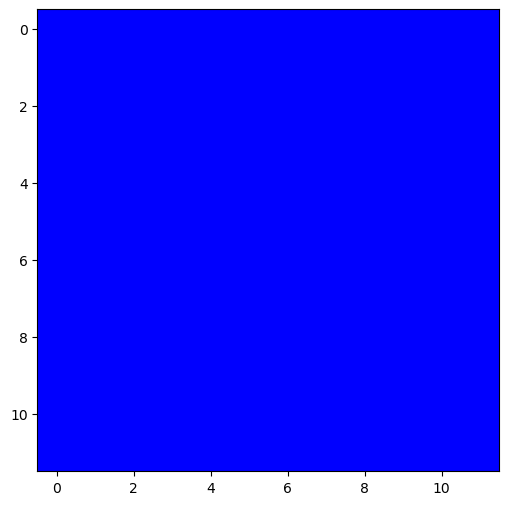

In [15]:
State = {
    "S" : 0.4, # infection chance
    "R" : 0, # lose recovery chance
    "I" : 0.2, # recovery chance
}

colors = {
    "S" : [0, 0, 255],
    "R" : [0, 255, 0],
    "I" : [255, 0, 0],
}

N = 12

time_limit = 120

fig, ax = plt.subplots(figsize=(6, 6))

people = np.array([["S" for _ in range(N)] for _ in range(N)])
stats = {
    "S" : np.empty(time_limit),
    "I" : np.empty(time_limit),
    "R" : np.empty(time_limit),
}

def people_to_colors(people_copy):
    global colors
    out_colors = [[colors[people_copy[i][j]] for j in range(N)] for i in range(N)]
    return out_colors

im = ax.imshow(people_to_colors(people), animated=True)

amount_of_starting_sick = 1

def infection_phase(people_copy):
    out_people = np.copy(people_copy)
    for i in range(N):
        for j in range(N):
            if people_copy[i][j] == "I":
                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        if (i + di >= 0 and i + di < N) and (j + dj >= 0 and j + dj < N):
                            if people_copy[i+di][j+dj] == "S" and np.random.rand() < State["S"]:
                                out_people[i+di][j+dj] = "I"
    return out_people

def recovery_phase(people_copy):
    out_people = np.copy(people_copy)
    for i in range(N):
        for j in range(N):
            if people_copy[i][j] == "I":
                if np.random.rand() < State["I"]:
                    out_people[i][j] = "R"
    return out_people

def lose_recovery_phase(people_copy):
    out_people = np.copy(people_copy)
    for i in range(N):
        for j in range(N):
            if people_copy[i][j] == "R":
                if np.random.rand() < State["R"]:
                    out_people[i][j] = "S"
    return out_people

def init():
    global people, stats
    stats = {
        "S" : np.empty(time_limit),
        "I" : np.empty(time_limit),
        "R" : np.empty(time_limit),
    }
    people = np.array([["S" for _ in range(N)] for _ in range(N)])

    for _ in range(amount_of_starting_sick):
        starting_sick_i = np.random.randint(0, N)
        starting_sick_j = np.random.randint(0, N)

        while people[starting_sick_i][starting_sick_j] != "S":
            starting_sick_i = np.random.randint(0, N)
            starting_sick_j = np.random.randint(0, N)
    
        people[starting_sick_i][starting_sick_j] = "I"


def advance(i, write_progress = False):
    if write_progress:
        sys.stdout.write("\r")
        sys.stdout.write(str(int(100*(i/time_limit))) + "%")
        sys.stdout.flush()
    global people
    people = infection_phase(people)
    people = lose_recovery_phase(people)
    people = recovery_phase(people)
    stats["S"][i] = np.count_nonzero(people == "S")
    stats["I"][i] = np.count_nonzero(people == "I")
    stats["R"][i] = np.count_nonzero(people == "R")


def anim_init():
    global people

    init()

    im.set_array(people_to_colors(people))
    return (im, )

def anim_advance(frame):
    if frame == 0:
        return (im, )
    global people

    advance(frame, True)
    
    im.set_array(people_to_colors(people))
    return (im, )

In [33]:
# create animation
anim = animation.FuncAnimation(
    fig,
    anim_advance,
    init_func=anim_init,
    frames=time_limit,
    interval=20,
    blit=True
)

# save to mp4 (requires ffmpeg); fps value can be chosen as desired
anim.save('SIR_animation.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

97%

99%9947.0


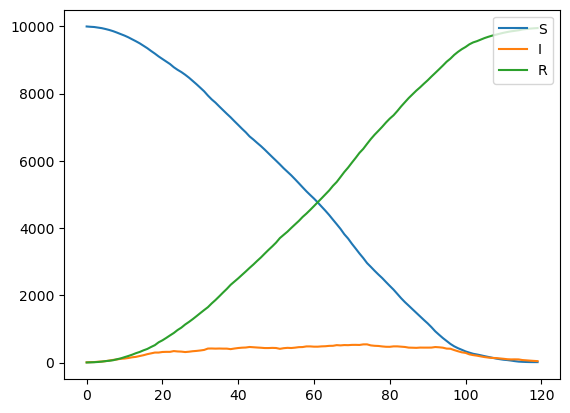

In [ ]:
# create graphs

init()
for i in range(time_limit):
    advance(i)
time_graph = np.arange(time_limit)
plt.plot(time_graph, stats["S"], label="S")
plt.plot(time_graph, stats["I"], label="I")
plt.plot(time_graph, stats["R"], label="R")


plt.legend(loc="upper right")
plt.show()

99% Estimated total time: 14.09928046616932 secondss

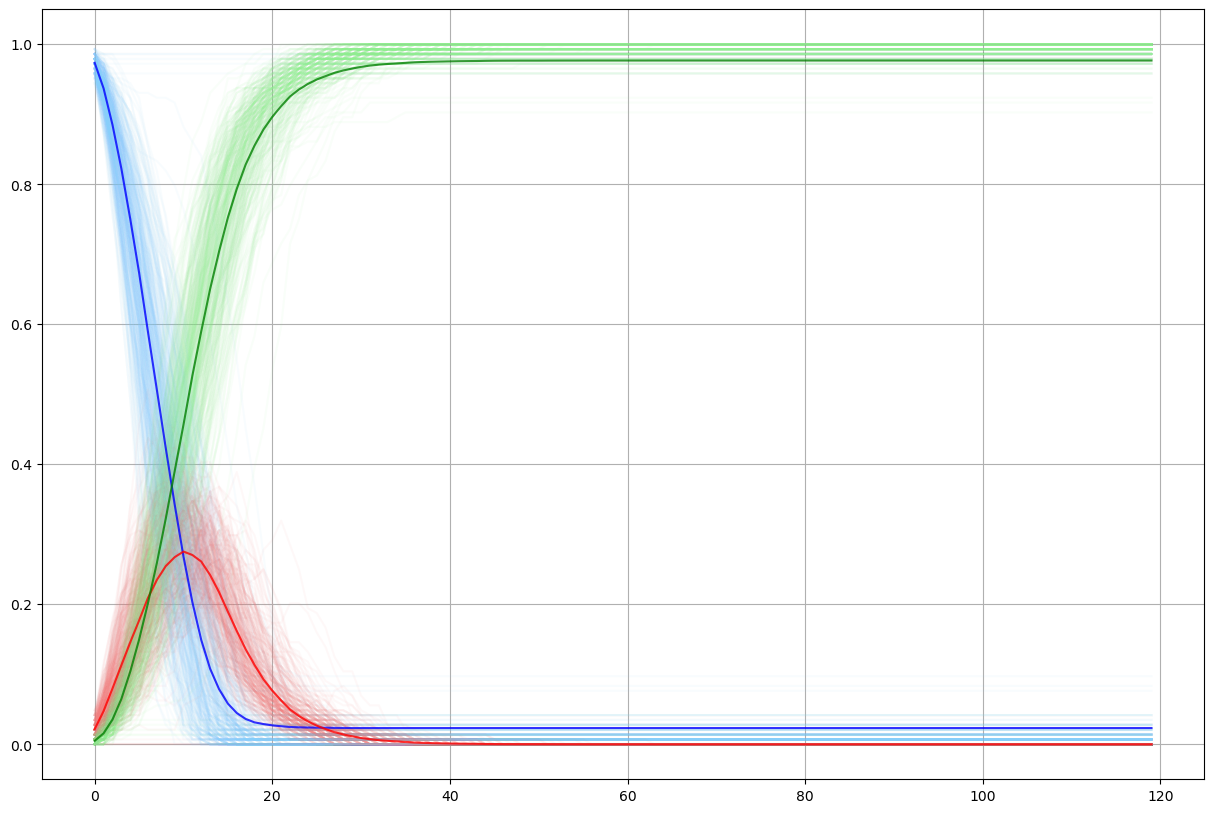

In [24]:
import time
SIR_simulations_to_run = 300
time_graph = np.arange(time_limit)

all_sims_stats = {
    "S" : np.empty((SIR_simulations_to_run, time_limit)),
    "I" : np.empty((SIR_simulations_to_run, time_limit)),
    "R" : np.empty((SIR_simulations_to_run, time_limit)),
}

start_seconds = time.time()
for simulation in range(SIR_simulations_to_run):
    progress = simulation/SIR_simulations_to_run
    sys.stdout.write("\r")
    sys.stdout.write(str(int(100*progress)) + "%")
    if simulation % 3 == 1:
        sys.stdout.write(" Estimated total time: " + str((1/progress)*(time.time()-start_seconds)) + " seconds")
    sys.stdout.flush()
    init()
    for i in range(time_limit):
        advance(i)

    all_sims_stats["S"][simulation] = stats["S"]
    all_sims_stats["I"][simulation] = stats["I"]
    all_sims_stats["R"][simulation] = stats["R"]

    plt.plot(time_graph, stats["S"]/people.size, color="lightskyblue", alpha=0.05)
    plt.plot(time_graph, stats["I"]/people.size, color="lightcoral", alpha=0.05)
    plt.plot(time_graph, stats["R"]/people.size, color="lightgreen", alpha=0.05)

plt.plot(time_graph, np.mean(all_sims_stats["S"], axis=0)/people.size, label="S mean", color="blue", alpha=0.8)
plt.plot(time_graph, np.mean(all_sims_stats["I"], axis=0)/people.size, label="I mean", color="red", alpha=0.8)
plt.plot(time_graph, np.mean(all_sims_stats["R"], axis=0)/people.size, label="R mean", color="green", alpha=0.8)

plt.grid()
plt.show()